In [38]:
import keras
from keras import regularizers, optimizers
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence

from keras.layers import Conv1D, Flatten, Activation, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow as tf
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)




Python:  3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:24:55) 
[Clang 11.1.0 ]
pandas:  1.4.1
numpy:  1.23.3
seaborn:  0.11.2
matplotlib:  3.5.1
sklearn:  1.0.2
Keras:  2.8.0
Tensorflow:  2.8.0


In [39]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()

In [40]:
df = pd.read_csv("./dataset/creditcard.csv", sep=",", index_col=None)
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [41]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [42]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,1.641931,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.350151,0
284803,1.641952,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,-0.254117,0
284804,1.641974,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,-0.081839,0
284805,1.641974,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.313249,0
284806,1.642058,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,0.514355,0


In [43]:
anomalies = df[df["Class"] == 1]
normal = df[df["Class"] == 0]

anomalies.shape, normal.shape


((492, 31), (284315, 31))

In [44]:

for f in range(0, 20):
    normal = normal.iloc[np.random.permutation(len(normal))]
    

data_set = pd.concat([normal[:2000], anomalies])

x_train, x_test = train_test_split(data_set, test_size = 0.4, random_state = 42)

x_train = x_train.sort_values(by=['Time'])
x_test = x_test.sort_values(by=['Time'])

y_train = x_train["Class"]
y_test = x_test["Class"]

x_train.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
244,-1.993130,0.073497,0.551033,0.451890,0.114964,0.822947,0.251480,0.296319,0.139497,-0.123050,...,-0.128758,-0.381932,0.151012,-1.363967,-1.389079,0.075412,0.231750,0.230171,-0.349271,0
623,-1.986644,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1.761758,1
787,-1.983969,0.142623,0.615165,1.421547,1.291217,-0.617997,-0.428988,0.678548,-0.367664,0.162607,...,-0.118524,0.073901,0.295627,0.740646,-1.544209,0.133510,-0.001466,0.014813,-0.130896,0
838,-1.983148,-0.931200,1.227638,2.084123,1.379637,0.188803,-0.857077,1.253347,-1.086969,-0.052162,...,-0.466862,-1.088931,0.017386,0.857610,-0.199970,-0.769820,-1.393776,-0.594883,-0.332199,0
857,-1.982874,-1.770831,0.034438,2.298969,1.346370,-0.148114,0.070059,-0.646819,0.515477,0.252558,...,0.098007,0.253605,-0.317748,0.078380,0.027607,-0.246428,-0.447484,-0.114312,-0.349231,0
881,-1.982558,-0.402286,0.517240,-0.161762,-0.961986,2.292411,3.732919,0.228197,0.865325,-0.155190,...,-0.147835,-0.450682,-0.075571,1.030690,-0.295726,0.159552,0.013624,0.131146,-0.162281,0
1707,-1.968787,-0.641355,0.803965,1.620765,-0.272534,-0.255840,-0.458779,0.594626,-0.156025,0.367681,...,-0.163133,-0.276211,-0.115719,0.553433,-0.123446,0.385518,-0.356910,-0.160822,-0.333239,0
1736,-1.968239,1.075480,-0.774728,0.206368,-1.326751,-0.663294,0.140661,-0.476861,0.286068,1.665496,...,0.031263,0.309081,-0.096786,-0.240785,0.449392,0.099112,0.031256,-0.000872,-0.151086,0
1844,-1.966470,-0.212561,-0.042747,2.122310,0.027128,-0.720182,0.436876,0.291809,0.008016,0.687422,...,-0.113531,0.006979,0.190117,0.140006,-0.597513,0.972923,-0.141463,-0.173137,0.013715,0
1903,-1.965628,-2.441499,1.673842,0.635624,-0.774727,-0.324322,0.487036,-1.368853,-3.198421,0.118282,...,3.697916,-1.591967,0.368239,-0.047118,-0.275087,0.343956,0.452182,0.032430,-0.349231,0


In [45]:
a = x_train[x_train["Class"] == 1]
n = x_train[x_train["Class"] == 0]

a.shape, n.shape


((294, 31), (1201, 31))

In [46]:
a = x_test[x_test["Class"] == 1]
n = x_test[x_test["Class"] == 0]

a.shape, n.shape

((198, 31), (799, 31))

In [47]:
print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))


Shapes:
x_train:(1495, 31)
y_train:(1495,)

x_test:(997, 31)
y_test:(997,)



In [48]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
input_shape = (x_train.shape[1], 1)

y_train = tensorflow.keras.utils.to_categorical(y_train, 2)
y_test = tensorflow.keras.utils.to_categorical(y_test, 2)


In [49]:
print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))
print("input_shape:{}\n".format(input_shape))

Shapes:
x_train:(1495, 31, 1)
y_train:(1495, 2)

x_test:(997, 31, 1)
y_test:(997, 2)

input_shape:(31, 1)



In [50]:

input_layer = Input(shape=(input_shape ))

#Series of temporal convolutional layers with dilations increasing by powers of 2.
conv_1 = Conv1D(filters=128, kernel_size=2, dilation_rate=1,
                padding='causal', strides=1,input_shape=input_shape,
                kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(input_layer)

#Dropout layer after each 1D-convolutional layer
drop_1 = SpatialDropout1D(0.05)(conv_1)

conv_2 = Conv1D(filters=128, kernel_size=2, dilation_rate=2,
                padding='causal',strides=1, kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(drop_1)

drop_2 = SpatialDropout1D(0.05)(conv_2)

conv_3 = Conv1D(filters=128, kernel_size=2, dilation_rate=4,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(drop_2)

drop_3 = SpatialDropout1D(0.05)(conv_3)

conv_4 = Conv1D(filters=128, kernel_size=2, dilation_rate=8,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.05),
                activation='relu')(drop_3)

drop_4 = SpatialDropout1D(0.05)(conv_4)

#Flatten layer to feed into the output layer
flat = Flatten()(drop_4)

output_layer = Dense(2, activation='softmax')(flat)

TCN = Model(inputs=input_layer, outputs=output_layer)

In [51]:
TCN.compile(loss='mean_squared_error',
              optimizer=tf.optimizers.Adam(lr=0.002),
              metrics=['mae', 'accuracy'])

checkpointer = ModelCheckpoint(filepath="model_TCN_creditcard.h5",
                               verbose=0,
                               save_best_only=True)

TCN.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 31, 1)]           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 31, 128)           384       
                                                                 
 spatial_dropout1d_8 (Spatia  (None, 31, 128)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_9 (Conv1D)           (None, 31, 128)           32896     
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 31, 128)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_10 (Conv1D)          (None, 31, 128)           3289

/Users/sjkang/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [52]:
TCN.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks = [TensorBoard(log_dir='./logs/TCN1')])


Epoch 1/10


2022-10-08 18:42:54.917313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 6.8644 - mae: 0.3460 - accuracy: 0.8455

2022-10-08 18:42:55.775949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 69ms/step - loss: 6.8644 - mae: 0.3460 - accuracy: 0.8455 - val_loss: 4.4176 - val_mae: 0.1495 - val_accuracy: 0.9569
Epoch 2/10
12/12 [==============================] - 1s 46ms/step - loss: 3.1348 - mae: 0.1059 - accuracy: 0.9645 - val_loss: 1.8743 - val_mae: 0.1010 - val_accuracy: 0.9609
Epoch 3/10
12/12 [==============================] - 1s 44ms/step - loss: 1.2660 - mae: 0.1072 - accuracy: 0.9639 - val_loss: 0.7061 - val_mae: 0.1181 - val_accuracy: 0.9609
Epoch 4/10
12/12 [==============================] - 1s 44ms/step - loss: 0.4635 - mae: 0.1095 - accuracy: 0.9592 - val_loss: 0.2565 - val_mae: 0.0934 - val_accuracy: 0.9559
Epoch 5/10
12/12 [==============================] - 1s 44ms/step - loss: 0.1717 - mae: 0.0959 - accuracy: 0.9632 - val_loss: 0.1080 - val_mae: 0.1004 - val_accuracy: 0.9609
Epoch 6/10
12/12 [==============================] - 1s 45ms/step - loss: 0.0835 - mae: 0.0952 - accuracy: 0.9639 - val_loss: 0.0697 - val_mae: 0.1

In [53]:

score = TCN.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.054726600646972656
Test accuracy: 0.07828062027692795


In [61]:
from sklearn.metrics import roc_auc_score

preds = TCN.predict(x_test)
y_pred = np.round(preds)
print(y_pred)
auc = roc_auc_score( y_pred, y_test)
print("AUC: {:.2%}".format (auc))

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
AUC: 97.42%


In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       799
           1       0.99      0.81      0.89       198

   micro avg       0.96      0.96      0.96       997
   macro avg       0.97      0.90      0.93       997
weighted avg       0.96      0.96      0.96       997
 samples avg       0.96      0.96      0.96       997



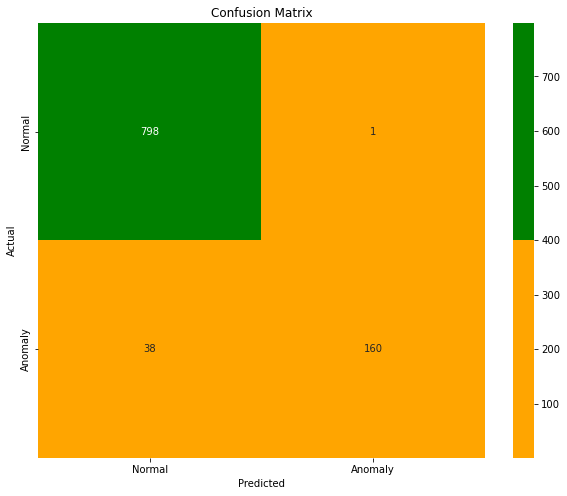

In [56]:
viz = Visualization()
y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)
viz.draw_confusion_matrix(y_test2, y_pred2)
